In [1]:
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
torch.set_default_dtype(torch.float32)
from flumen import CausalFlowModel,TrunkNet, TrajectoryDataset
from flumen.utils import pack_model_inputs, plot_amari, trajectory,plot_space_time_flat_trajectory_V2
from torch.utils.data import DataLoader

from generate_data import make_trajectory_sampler

from argparse import ArgumentParser
import deepxde as dde
import yaml
from pathlib import Path
import sys
from pprint import pprint
from time import time
import os
os.chdir("C:/Users/20192139/Documents/5ARG45 - Thesis/Code/FlowFunction/flumen")  # Change this to your actual path
import wandb
import pickle
from flumen import CausalFlowModel, print_gpu_info, TrajectoryDataset, TrunkNet
import torch
import torch.nn as nn
device = torch.device("cpu")

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [1]:
class CausalFlowModel_(nn.Module):

    def __init__(self,
                 state_dim,
                 control_dim,
                 output_dim,
                 control_rnn_size,
                 control_rnn_depth,
                 encoder_size,
                 encoder_depth,
                 decoder_size,
                 decoder_depth,
                 use_nonlinear,
                 IC_encoder_decoder,
                 regular,
                 use_conv_encoder,
                 trunk_size_svd,
                 trunk_size_extra,
                 NL_size,
                 trunk_modes,
                 trunk_model,
                 use_batch_norm):
        super(CausalFlowModel, self).__init__()

        self.state_dim = state_dim
        self.control_dim = control_dim
        self.output_dim = output_dim
        self.control_rnn_size = control_rnn_size
        self.trunk_modes = trunk_modes
        self.trunk_size_svd = trunk_size_svd
        self.trunk_size_extra = trunk_size_extra
        self.NL_size = NL_size
        self.conv_encoder_enabled = use_conv_encoder
        self.nonlinear_enabled = use_nonlinear 
        self.IC_encoder_decoder_enabled = IC_encoder_decoder
        self.regular_enabled = regular
        self.basis_function_modes = self.trunk_modes  
        self.out_size_decoder = self.basis_function_modes
        self.in_size_encoder = self.control_dim = self.basis_function_modes
        self.control_rnn_depth = control_rnn_depth

        self.u_rnn = torch.nn.LSTM(
            input_size=1 + self.control_dim,
            hidden_size=control_rnn_size,
            batch_first=True,
            num_layers=control_rnn_depth,
            dropout=0,
        )

        ### Enforce IC ###
        if self.IC_encoder_decoder_enabled:
            assert control_rnn_size > self.trunk_modes, "Control RNN size must be greater than trunk modes"	
            x_dnn_osz = control_rnn_depth * (control_rnn_size-self.trunk_modes)
        else: 
            x_dnn_osz = control_rnn_depth * control_rnn_size
            
            ### Flow decoder (MLP) ###
            self.u_dnn = FFNet(in_size=control_rnn_size,
                            out_size=self.out_size_decoder,
                            hidden_size=decoder_depth *
                            (decoder_size * control_rnn_size, ),
                            use_batch_norm=use_batch_norm)
        
        ### Flow encoder (CNN) ###
        if self.conv_encoder_enabled:
            self.x_dnn = CNN_encoder(in_size=self.in_size_encoder,
                           out_size=x_dnn_osz,use_batch_norm=use_batch_norm)
            
        ### Flow encoder (MLP) ###
        else:
            self.x_dnn = FFNet(in_size=self.in_size_encoder,
                           out_size=x_dnn_osz,
                           hidden_size=encoder_depth *
                           (encoder_size * x_dnn_osz, ), 
                           use_batch_norm=use_batch_norm)

        ### Trunk (MLP) ###
        self.trunk_svd = trunk_model # Trained on SVD
        if trunk_modes > state_dim:
            self.trunk_extra = TrunkNet(in_size=256,out_size=self.trunk_modes-self.state_dim,hidden_size=self.trunk_size_extra,use_batch_norm=False,dropout_prob=0.1)
        else: 
            self.trunk_extra = None

        ### Nonlinear decoder (MLP) ###
        self.output_NN = FFNet(in_size=trunk_modes,out_size = 1,hidden_size=self.NL_size,use_batch_norm=use_batch_norm)

    def forward(self, x, rnn_input,locations, deltas):

        ### Projection ###
        if self.regular_enabled == False:
            unpadded_u, unpacked_lengths = pad_packed_sequence(rnn_input, batch_first=True)     # unpack input
            u = unpadded_u[:, :, :-1]                                                           # extract inputs values
            if self.trunk_extra is not None:                 
                trunk_output_svd = self.trunk_svd(locations.view(-1, 1)) 
                trunk_output_extra = self.trunk_extra(locations.view(-1, 1))
                trunk_output = torch.cat([trunk_output_svd, trunk_output_extra], dim=1)  
            else:
                trunk_output = self.trunk_svd(locations.view(-1, 1)) 
            x = torch.einsum("ni,bn->bi",trunk_output[:, :self.basis_function_modes],x) # a(0)
            u = torch.einsum('ni,btn->bti',trunk_output[:, :self.basis_function_modes],u) # projected inputs
            u_deltas = torch.cat((u, deltas), dim=-1)          
            rnn_input = pack_padded_sequence(u_deltas, unpacked_lengths, batch_first=True)      # repack RNN input

        
        ### Flow encoder ###
        h0 = self.x_dnn(x)
        if self.IC_encoder_decoder_enabled:
            x_repeated = x.repeat(1,self.control_rnn_depth)
            x_chunks = torch.chunk(x_repeated,chunks=self.control_rnn_depth, dim=1)
            enc_chunks = torch.chunk(h0, chunks=self.control_rnn_depth, dim=1)
            h0 = [torch.cat([b_part, a_part], dim=1) for b_part, a_part in zip(x_chunks, enc_chunks)]
            h0 = torch.stack(h0)
        else:
            h0 = torch.stack(h0.split(self.control_rnn_size, dim=1))
        c0 = torch.zeros_like(h0)

        ### Flow RNN ###
        rnn_out_seq_packed, _ = self.u_rnn(rnn_input, (h0,c0))
        h, h_lens = torch.nn.utils.rnn.pad_packed_sequence(rnn_out_seq_packed,
                                                           batch_first=True)
        h_shift = torch.roll(h, shifts=1, dims=1)
        h_shift[:, 0, :] = h0[-1]
        encoded_controls = (1 - deltas) * h_shift + deltas * h

        ### Flow decoder ###
        if self.IC_encoder_decoder_enabled:
            output_flow = encoded_controls[range(encoded_controls.shape[0]),
                                             h_lens - 1, :][:,:self.trunk_modes]
                     
        else:
            output_flow = self.u_dnn(encoded_controls[range(encoded_controls.shape[0]),
                                             h_lens - 1, :])
        
        ### Nonlinearity ###
        if self.nonlinear_enabled:
            output = torch.einsum("ni,bi->bni",trunk_output[:, :self.basis_function_modes],output_flow)
            batch_size = output.shape[0]
            output = self.output_NN(output)
            output = output.view(batch_size,-1)
            
        ### Inner product ###
        else: 
            output = torch.einsum("ni,bi->bn",trunk_output[:, :self.basis_function_modes],output_flow)
        return output, trunk_output


NameError: name 'nn' is not defined

## Helper functions

In [2]:
def pack_model_inputs_(x0, t, u, delta):
    t = torch.Tensor(t.reshape((-1, 1))).flip(0)
    x0 = torch.Tensor(x0.reshape((1, *x0.shape))).repeat(t.shape[0], *([1] * len(x0.shape)))
    rnn_inputs = torch.empty((t.shape[0], u.shape[0], u.shape[1] + 1))
    lengths = torch.empty((t.shape[0], ), dtype=torch.long)
    device = torch.device("cpu")

    for idx, (t_, u_) in enumerate(zip(t, rnn_inputs)):
        control_seq = torch.from_numpy(u)
        deltas = torch.ones((u.shape[0], 1))

        seq_len = 1 + int(np.floor(t_ / delta))
        lengths[idx] = seq_len
        deltas[seq_len - 1] = ((t_ - delta * (seq_len - 1)) / delta).item()
        deltas[seq_len:] = 0.
        control_seq = control_seq.to(device)
        deltas = deltas.to(device)
        u_[:] = torch.hstack((control_seq, deltas))
    
    lengths = lengths.to('cpu')
    u_packed = torch.nn.utils.rnn.pack_padded_sequence(rnn_inputs,
                                                       lengths,
                                                       batch_first=True,
                                                       enforce_sorted=True)

    return x0, t, u_packed, rnn_inputs[:, :lengths[0], -1].unsqueeze(-1)

def return_model(path):
    api = wandb.Api()
    model_artifact = api.artifact(path)
    model_path = Path(model_artifact.download())
    model_run = model_artifact.logged_by()
    print(model_run.summary)
    device = "cpu"
    # Load model state dictionary
    with open(model_path / "state_dict.pth", 'rb') as f:
        state_dict = torch.load(f, map_location=torch.device("cpu"))  # Ensure compatibility

    with open(model_path / "metadata.yaml", 'r') as f:
        metadata: dict = yaml.load(f, Loader=yaml.FullLoader)
    pprint(metadata)
    print(metadata["args"])
    trunk_model = TrunkNet(in_size=256,out_size=100,hidden_size=metadata['args']['trunk_size_svd'],use_batch_norm=False)

    model = CausalFlowModel(**metadata["args"],trunk_model=trunk_model)
    model.load_state_dict(state_dict)
    model.eval()
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total trainable parameters: {total_params}")
    return model

## Generate / Load data

In [2]:
# with open('data_generation/brian2_mexhat.yaml', 'r') as f:
#         settings: dict = yaml.load(f, Loader=yaml.FullLoader)
# sampler = make_trajectory_sampler(settings)  
# time_horizon = 50 # [ms]
# n_samples = 100 # number of samples per trajectory
# x0_list = []
# t_list = []
# y_list = []
# u_list = []
# deltas_list = []
# u_don = []
# f_don = []
# n_trajectories = 100
# # save 100 test trajectories
# for i in range(n_trajectories):
#     x0, t, y, u,_ = sampler.get_example(time_horizon=time_horizon,n_samples=int(n_samples))
#     locations = torch.tensor(sampler._dyn.locations,dtype=torch.get_default_dtype())
#     u_don.append(y)
#     f_don.append(u)
#     x0_feed, t_feed, u_feed, deltas_feed = pack_model_inputs_(
#             x0, t, u, sampler._dyn.delta)
#     x0_list.append(x0_feed)
#     t_list.append(t_feed)
#     y_list.append(y)
#     u_list.append(u_feed)
#     deltas_list.append(deltas_feed)
    
# data = {
#     "f_don":f_don,
#     "x0": x0_list,
#     "t": t_list,
#     "y": y_list,
#     "u": u_list,
#     "deltas":deltas_list,
#     "locations":locations
# }
  
# # # # # Save as a .pt file
# torch.save(data, "data/Brian2/mexhat_test_vs_don_equaltimesteps.pt")

# # # load data
test_data = torch.load("data/Brian2/gaussian_test_vs_don_equaltimesteps.pt")


WARNING    C:\Users\20192139\AppData\Local\Temp\ipykernel_7552\102327994.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_data = torch.load("data/Brian2/gaussian_te

### DeepOnet predictions 

In [12]:
nx = 100
input_dim_trunk = 2
input_dim_branch = 2* nx

# data = dde.data.TripleCartesianProd(x_train,y_train, x_test, y_test)
# net = dde.nn.DeepONetCartesianProd(
#     [input_dim_branch, 512, 512],
#     [input_dim_trunk, 512, 512, 512],
#     "relu",
#     "Glorot normal",
# )

net_deep = dde.nn.DeepONetCartesianProd(
    [input_dim_branch, 320, 320,320,320,320,320,320],
    [input_dim_trunk, 320, 320,320,320,320,320,320],
    "relu",
    "Glorot normal",
)
model = dde.Model([], net_deep)

def mae_torch(y_true, y_pred):
    if not torch.is_tensor(y_true):
        y_true = torch.tensor(y_true)
    if not torch.is_tensor(y_pred):
        y_pred = torch.tensor(y_pred)
    return torch.mean(torch.abs(y_true - y_pred))

# DON_model = dde.Model([], net)
DON_model = dde.Model([], net_deep)

DON_model.compile(
    "adam",
    lr=1e-3,
    decay=("inverse time", 1, 1e-4),
    metrics=[mae_torch],
)
# DON_model.restore("models_DON/DeepONet/gaussian_T2500_new/-11000.pt")
# DON_model.restore("models_DON/DeepONet/gaussian_T2500_deep/-3402.pt") # L1
DON_model.restore("models_DON/DeepONet/gaussian_T2500_deep_1208/L1-831.pt") # L2
### Arrange the trunk inputs ###
x = test_data['locations'].cpu() * 100
t = np.linspace(0.5,10,20)
nt = len(t)
nx = len(x)
t, x = np.meshgrid(t, x.numpy(), indexing='ij') # make grid
xt = np.vstack((np.ravel(x), np.ravel(t))).T # combine them --> trunk inputs (nt*nx,2)

y_pred_don = []
y_pred_don_short_segments = []
### iterate over the trajectories
for i in range(0,len(test_data['x0'])):
    y_trajectory = test_data['y'][i]
    y_pred = np.zeros_like(y_trajectory) # prediction array
    y_pred_short_segments = np.zeros_like(y_trajectory)
    
    forcing_trajectory = test_data['f_don'][i]
    y_pred[0] = y_trajectory[0] # set pred IC as true IC
    y_pred_short_segments[0] = y_trajectory[0]
    k = 5
    for j in range(0,5): # iterate over segment length for DeepONet (5 forcing inputs = 5 segments per trajectory)
        u0 = y_pred[j*20]
        y0 = y_trajectory[j*20] # ground truth IC
        f = forcing_trajectory[k]
        
        u0_and_f = np.concatenate((u0, f)).reshape(1,-1)  # shape N, nx2
        y0_and_f = np.concatenate((y0, f)).reshape(1,-1)  # shape N, nx2

        pred = DON_model.predict((u0_and_f, xt))
        pred = pred.reshape(nt, nx)
        
        pred_short_segments = DON_model.predict((y0_and_f, xt))
        pred_short_segments = pred_short_segments.reshape(nt, nx)
        
        y_pred[j*20+1:(j+1)*20+1] = pred
        y_pred_short_segments[j*20+1:(j+1)*20+1] = pred_short_segments
        k += 10
        
    y_pred_don.append(y_pred)    
    y_pred_don_short_segments.append(y_pred_short_segments)  
    
y_pred_don = np.array(y_pred_don)
y_pred_don_short_segments = np.array(y_pred_don_short_segments)


Compiling model...
'compile' took 0.000378 s



## Flow prediction on single dataset

In [4]:
mse_model ="marijn-eindhoven-university-of-technology/Ablation/flow_model-brian_T2500_S100_LOOP-A_NL_100_MSE:v25"
l1_model = "marijn-eindhoven-university-of-technology/LIF_L1_sweep/uyukxc6h:v51"
l1_model2 = "marijn-eindhoven-university-of-technology/Ablation/flow_model-brian_T2500_S100_LOOP-A_Innerproduct_50_L1:v36"
FLOW_model = return_model(l1_model2)
device = "cpu"
FLOW_model.to(device)
trajectory_losses = []
y_pred_flow = []
for i in range(0,len(test_data['x0'])):
    with torch.no_grad():
        x0_feed = test_data['x0'][i]
        t_feed = test_data['t'][i]
        u_feed = test_data['u'][i]
        deltas_feed = test_data['deltas'][i]
        y_pred, basis_functions = FLOW_model(x0_feed.to(device), u_feed.to(device),test_data['locations'].to(device),deltas_feed.to(device))
#         y_pred = torch.flip(y_pred, dims=[0])
        y_pred_flow.append(y_pred.to('cpu').numpy())
        
y_pred_flow = np.array(y_pred_flow)

only_flow = True
if only_flow == True:
    losses_flow_total = []
    # iterate over trajectories
    for i in range(len(test_data['y'])):
        y = test_data['y'][i]
        y_pred_flow_i = np.flip(y_pred_flow[i], axis=0)
        losses_flow_total.append(np.mean(np.abs(y_pred_flow_i - y))) # L1
#         losses_flow_total.append(np.mean((y_pred_flow_i - y)**2)) # L2
    losses_flow_total = np.array(losses_flow_total)
    print('meanerror flow: ', np.mean(losses_flow_total), "std: ", np.std(losses_flow_total))
    

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb:   2 of 2 files downloaded.  


True


WARNING    C:\Users\20192139\AppData\Local\Temp\ipykernel_27588\480051527.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f, map_location=torch.

{'Flownet/Best_epoch': 108, 'Flownet/Test trajectory': {'_type': 'image-file', 'format': 'png', 'height': 700, 'path': 'media/images/Flownet/Test trajectory_143_61e956e443b3eb963e1d.png', 'sha256': '61e956e443b3eb963e1db866840d6f8d2f27b8ee072dad69a93a0db170cfc5f9', 'size': 256951, 'width': 1500}, 'Flownet/best_epoch': 108, 'Flownet/best_test': 0.04302333666931225, 'Flownet/best_train': 0.029905169978586076, 'Flownet/best_val': 0.04034448878816034, 'Flownet/epoch': 138, 'Flownet/lr': 1.1341884864431345e-07, 'Flownet/test_loss': 0.04283926206864888, 'Flownet/time': 12367.123999357224, 'Flownet/train_loss': 0.029722369949495217, 'Flownet/train_loss_data': 0.029722369949495217, 'Flownet/val_loss': 0.0404765189495645, '_runtime': 12501.582794937, '_step': 174, '_timestamp': 1754680448.9125166, '_wandb': {'runtime': 12501}}
{'args': {'IC_encoder_decoder': False,
          'NL_size': [0],
          'control_dim': 100,
          'control_rnn_depth': 1,
          'control_rnn_size': 250,
      

WARNING    C:\Users\20192139\Anaconda3\envs\Thesisenv\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
 [py.warnings]


Total trainable parameters: 971151
torch.Size([101, 50])
torch.Size([101, 50])
torch.Size([101, 50])
torch.Size([101, 50])
torch.Size([101, 50])
torch.Size([101, 50])
torch.Size([101, 50])
torch.Size([101, 50])
torch.Size([101, 50])
torch.Size([101, 50])
torch.Size([101, 50])
torch.Size([101, 50])
torch.Size([101, 50])
torch.Size([101, 50])
torch.Size([101, 50])
torch.Size([101, 50])
torch.Size([101, 50])
torch.Size([101, 50])
torch.Size([101, 50])
torch.Size([101, 50])
torch.Size([101, 50])
torch.Size([101, 50])
torch.Size([101, 50])
torch.Size([101, 50])
torch.Size([101, 50])
torch.Size([101, 50])
torch.Size([101, 50])
torch.Size([101, 50])
torch.Size([101, 50])
torch.Size([101, 50])
torch.Size([101, 50])
torch.Size([101, 50])
torch.Size([101, 50])
torch.Size([101, 50])
torch.Size([101, 50])
torch.Size([101, 50])
torch.Size([101, 50])
torch.Size([101, 50])
torch.Size([101, 50])
torch.Size([101, 50])
torch.Size([101, 50])
torch.Size([101, 50])
torch.Size([101, 50])
torch.Size([101, 50

## for only FlowNet results

In [26]:
losses_flow_total 

array([0.016952  , 0.02111168, 0.0168671 , 0.02438343, 0.04586506,
       0.01459172, 0.02009378, 0.03517209, 0.01718787, 0.03250846,
       0.09414344, 0.02760683, 0.01232013, 0.02023327, 0.02165304,
       0.01778529, 0.11544674, 0.04401908, 0.01881662, 0.01407057,
       0.01594102, 0.02929976, 0.01125031, 0.01961024, 0.01666302,
       0.03632471, 0.01921546, 0.01050338, 0.0441281 , 0.03380874,
       0.06402912, 0.01992448, 0.00990835, 0.02055482, 0.01509512,
       0.02513611, 0.0140701 , 0.03076769, 0.06223821, 0.02801221,
       0.07967205, 0.02356582, 0.026197  , 0.01101148, 0.01367395,
       0.01737588, 0.01645469, 0.01875821, 0.02046537, 0.02319652,
       0.01842545, 0.01261666, 0.07950688, 0.01943943, 0.01275913,
       0.01221086, 0.01115356, 0.01122772, 0.01151588, 0.03142848,
       0.02429796, 0.03266125, 0.02442622, 0.03034023, 0.01404058,
       0.01773336, 0.01683833, 0.01333582, 0.02873621, 0.02917642,
       0.01479343, 0.02186594, 0.01704018, 0.01159953, 0.01491

In [24]:
print(len(test_data['t'][i]))

51


## save / load  results

In [14]:
np.savez(
    "results/DON_vs_FLOW/mexhat.npz",
    locations=test_data['locations'].cpu().numpy(),
    y=test_data['y'],
    y_pred_flow=y_pred_flow,
    y_pred_don=y_pred_don,
    y_pred_don_short_segments=y_pred_don_short_segments,
    t_feed=t_feed.cpu().numpy()
)

results = np.load("results/DON_vs_FLOW/mexhat.npz")
# results['y_pred_flow'].shape


In [15]:
losses_flow_total = []
losses_don_total = []
losses_don_ss_total = [] # shorter segments, using ground truth as IC
# iterate over trajectories
for i in range(results['y'].shape[0]):
    y = results['y'][i]
    y_pred_flow_i = np.flip(results['y_pred_flow'][i], axis=0)
    y_pred_don_i = results['y_pred_don'][i]
    y_pred_don_ss_i = results['y_pred_don_short_segments'][i]
    losses_flow_total.append(np.mean(np.abs(y_pred_flow_i - y)))
    losses_don_total.append(np.mean(np.abs(y_pred_don_i - y)))
    losses_don_ss_total.append(np.mean(np.abs(y_pred_don_ss_i - y)))
    
losses_flow_total = np.array(losses_flow_total)
losses_don_total = np.array(losses_don_total)
losses_don_ss_total = np.array(losses_don_ss_total)
print('meanerror flow: ', np.mean(losses_flow_total), "std: ", np.std(losses_flow_total))
print('meanerror don: ', np.mean(losses_don_total), "std: ", np.std(losses_don_total))
print('mean error don shorter segments: ', np.mean(losses_don_ss_total), "std: ", np.std(losses_don_ss_total))



meanerror flow:  0.3355549830279528 std:  0.02371081406168299
meanerror don:  0.353557951743661 std:  0.030774491771183292
mean error don shorter segments:  0.3796718404381719 std:  0.03951718835541362


## Save trajectory for plotting

In [20]:
input = test_data['f_don'][9]
input = input[:-1,:]
print(input.shape)
input_expanded = np.repeat(input, repeats=2, axis=0)
input_final = np.vstack([input_expanded,input[-1,:]])
print(input_final.shape)


(50, 100)
(101, 100)


In [21]:
### DeepOnet needs to be flipped for flipping that happens in plotting fuction
np.savez(
    "plot/data/don_vs_flow/input_9.npz",
    input = input_final,
#     y_pred_don= np.flip(results['y_pred_don'][trajectory], axis=0),
#     y_pred_don_ss=np.flip(results['y_pred_don_short_segments'][trajectory], axis=0),
#     t_feed=results['t_feed'].reshape(-1,1),
#     y=results['y'][trajectory]
)



30
(101, 1)
60
(101, 1)
90
(101, 1)


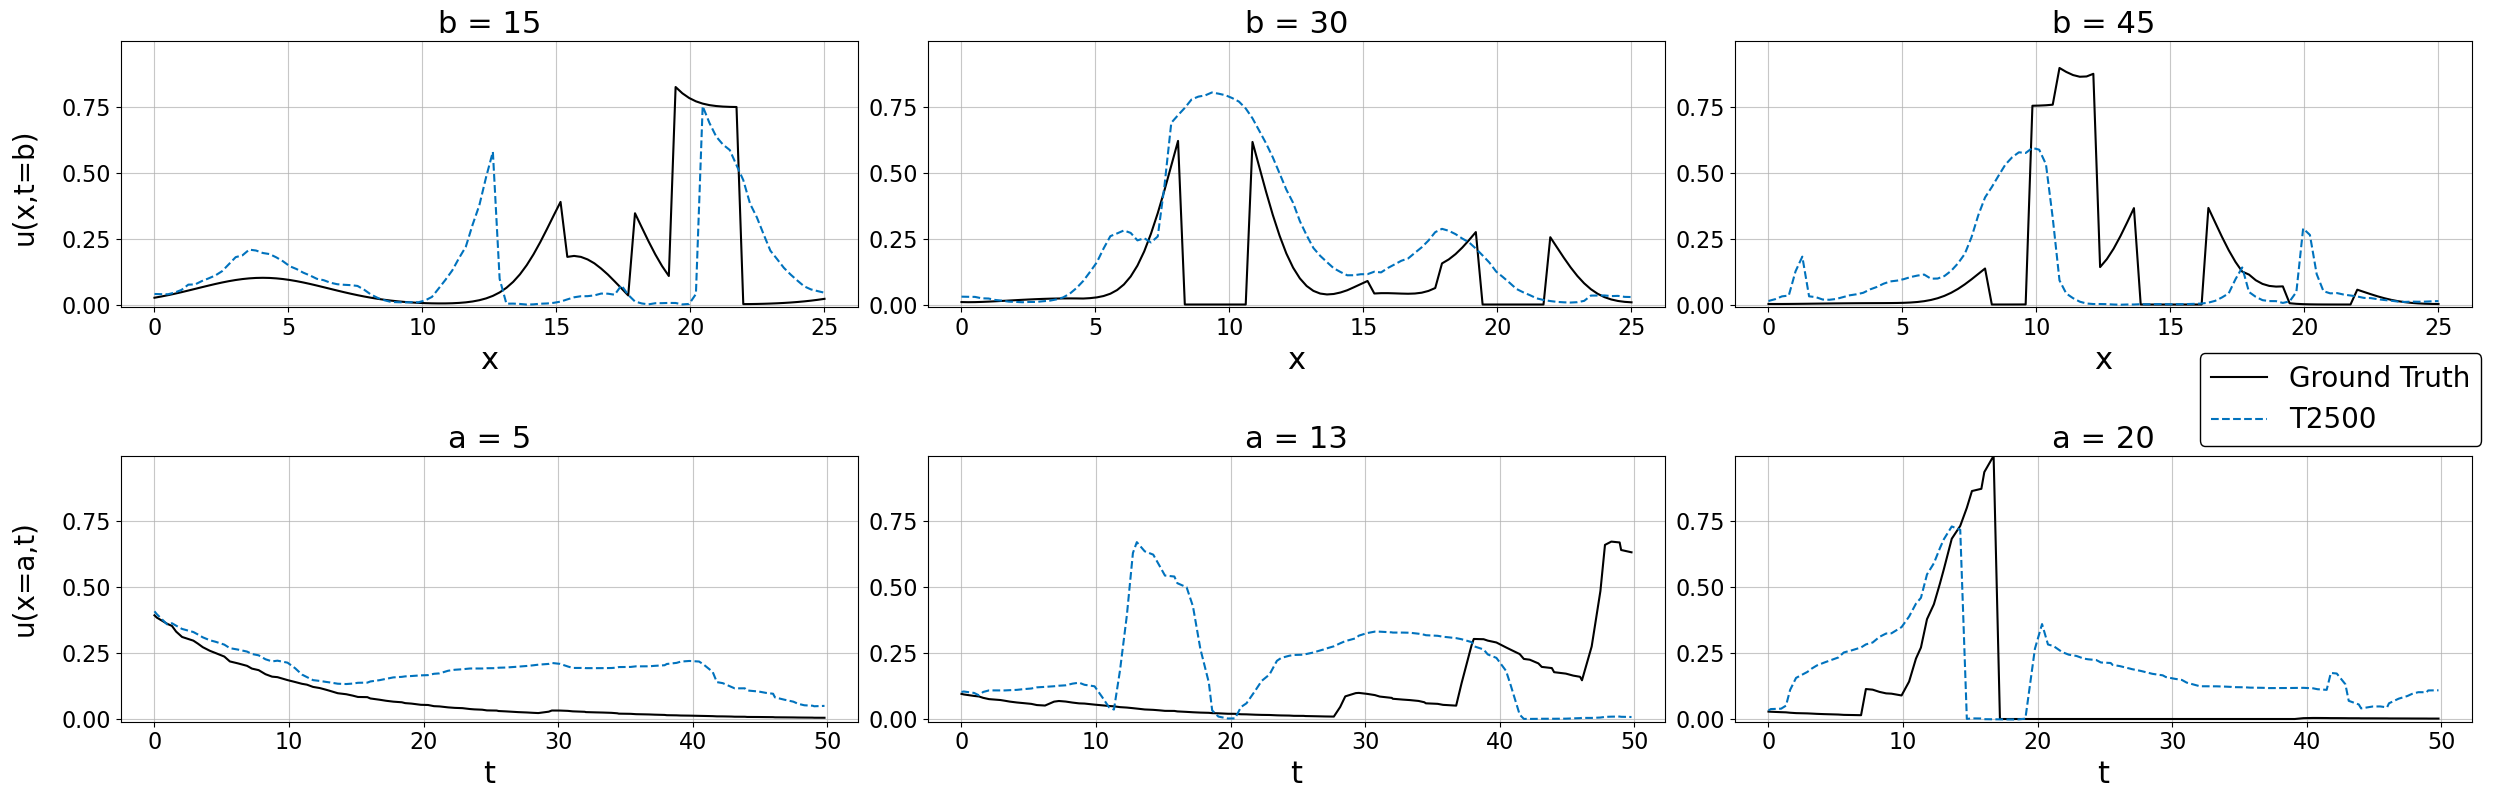

In [42]:
# y_pred = np.flip(results['y_pred_flow'][trajectory], axis=0)
# Don = np.flip(results['y_pred_don_short_segments'][0], axis=0)
# trajectory = 56
# trajectory = 72
trajectory = 10

fig = plot_trajectory_multiple_trajectories(test_data['y'][trajectory], [y_pred_flow[trajectory]],t_feed.cpu().numpy(),labels=["Ground Truth", "T2500"],time_indices=[30, 60,90],space_indices=[21, 50, 78,])
plt.show()

In [63]:
# Don = np.flip(results['y_pred_don_short_segments'][0], axis=0)
trajectory = 39
# trajectory = 35
fig = plot_trajectory_multiple_trajectories(test_data['y'][trajectory], [results['y_pred_flow'][trajectory]],t_feed,labels=["Ground Truth", "T2500"],time_indices=[30, 60,99],space_indices=[21, 50, 78,])
plt.show()

NameError: name 'results' is not defined

In [315]:
trajectory = 39


(101, 100)

In [57]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

def plot_ground_truth_and_predictions(y, y_pred_list, t_feed, labels=None):
                                      
    """
    Plots ground truth on top, followed by multiple model predictions as heatmaps.

    Parameters
    ----------
    y_true : np.ndarray
        Ground truth 2D array (e.g., shape (101, 100)).
    predictions : list of np.ndarray
        List of 2D prediction arrays with same shape as y_true.
    model_names : list of str, optional
        Names for the models (same order as predictions).
    extent : list [xmin, xmax, ymin, ymax]
        Coordinate range for imshow.
    vmin, vmax : float
        Color scale min/max.
    """

    n_plots = 1 + len(y_pred_list)  # ground truth + predictions

    # === Plot style ===
    mpl.rcParams.update({
        'text.usetex': False,
        'axes.titlesize': 22,
        'axes.labelsize': 22,
        'xtick.labelsize': 16,
        'ytick.labelsize': 16,
        'legend.fontsize': 20,
        'font.size': 18,
        'axes.grid': True,
        'grid.linestyle': '-',
        'grid.alpha': 0.7,
        'lines.linewidth': 1.5,
        'figure.figsize': [25, 6 * n_plots],  # height scales with plots
    })

    y_np = y.T
    y_pred_np_list = [np.flip(y_pred, axis=0).T for y_pred in y_pred_list]
    t_feed = np.flip(t_feed)
    all_data = [y_np] + y_pred_np_list
    global_min = min(arr.min() for arr in all_data)
    global_max = max(arr.max() for arr in all_data)
    
    fig, axes = plt.subplots(n_plots, 1, constrained_layout=False)
    extent=[0, 50, 0, 25]
    vmin=0
    vmax=1
    # If only 1 prediction, axes might not be a list
    if n_plots == 1:
        axes = [axes]

#     # --- Plot ground truth ---
#     im = axes[0].imshow(y_np, aspect='auto', origin='lower',
#                         cmap='viridis', vmin=vmin, vmax=vmax, extent=extent)
#     axes[0].set_title("Ground Truth")
#     axes[0].set_xlabel('Time index')
#     axes[0].set_ylabel('Space index')
#     fig.colorbar(im, ax=axes[0], label='Value')

    # --- Plot predictions ---
    for i, pred in enumerate(all_data):
        im = axes[i].imshow(pred, aspect='auto', origin='lower',
                              cmap='viridis', vmin=vmin, vmax=vmax, extent=extent)
        name = labels[i] if labels else f"Prediction {i+1}"
        axes[i].set_title(name)
        axes[i].set_xlabel('t')
        axes[i].set_ylabel('x')
        fig.colorbar(im, ax=axes[i], label='u(x,t)')

    fig.tight_layout(rect=[0.02, 0.02, 1, 1],h_pad=2.0,w_pad=1)  # leave space for labels and legend



# === Example usage ===
y_true = np.random.rand(101, 100)
y_pred1 = np.random.rand(101, 100)
y_pred2 = np.random.rand(101, 100)

# fig = plot_ground_truth_and_predictions(
#     results['y'][trajectory],
#     [results['y_pred_flow'][trajectory],np.flip(results['y_pred_don'][trajectory], axis=0),np.flip(results['y_pred_don_short_segments'][trajectory], axis=0)],
#     results['t_feed'],
#     labels=["reference","FlowNet","DeepONet", "DeepONet Shorter Segments"]
# )
# plt.show()

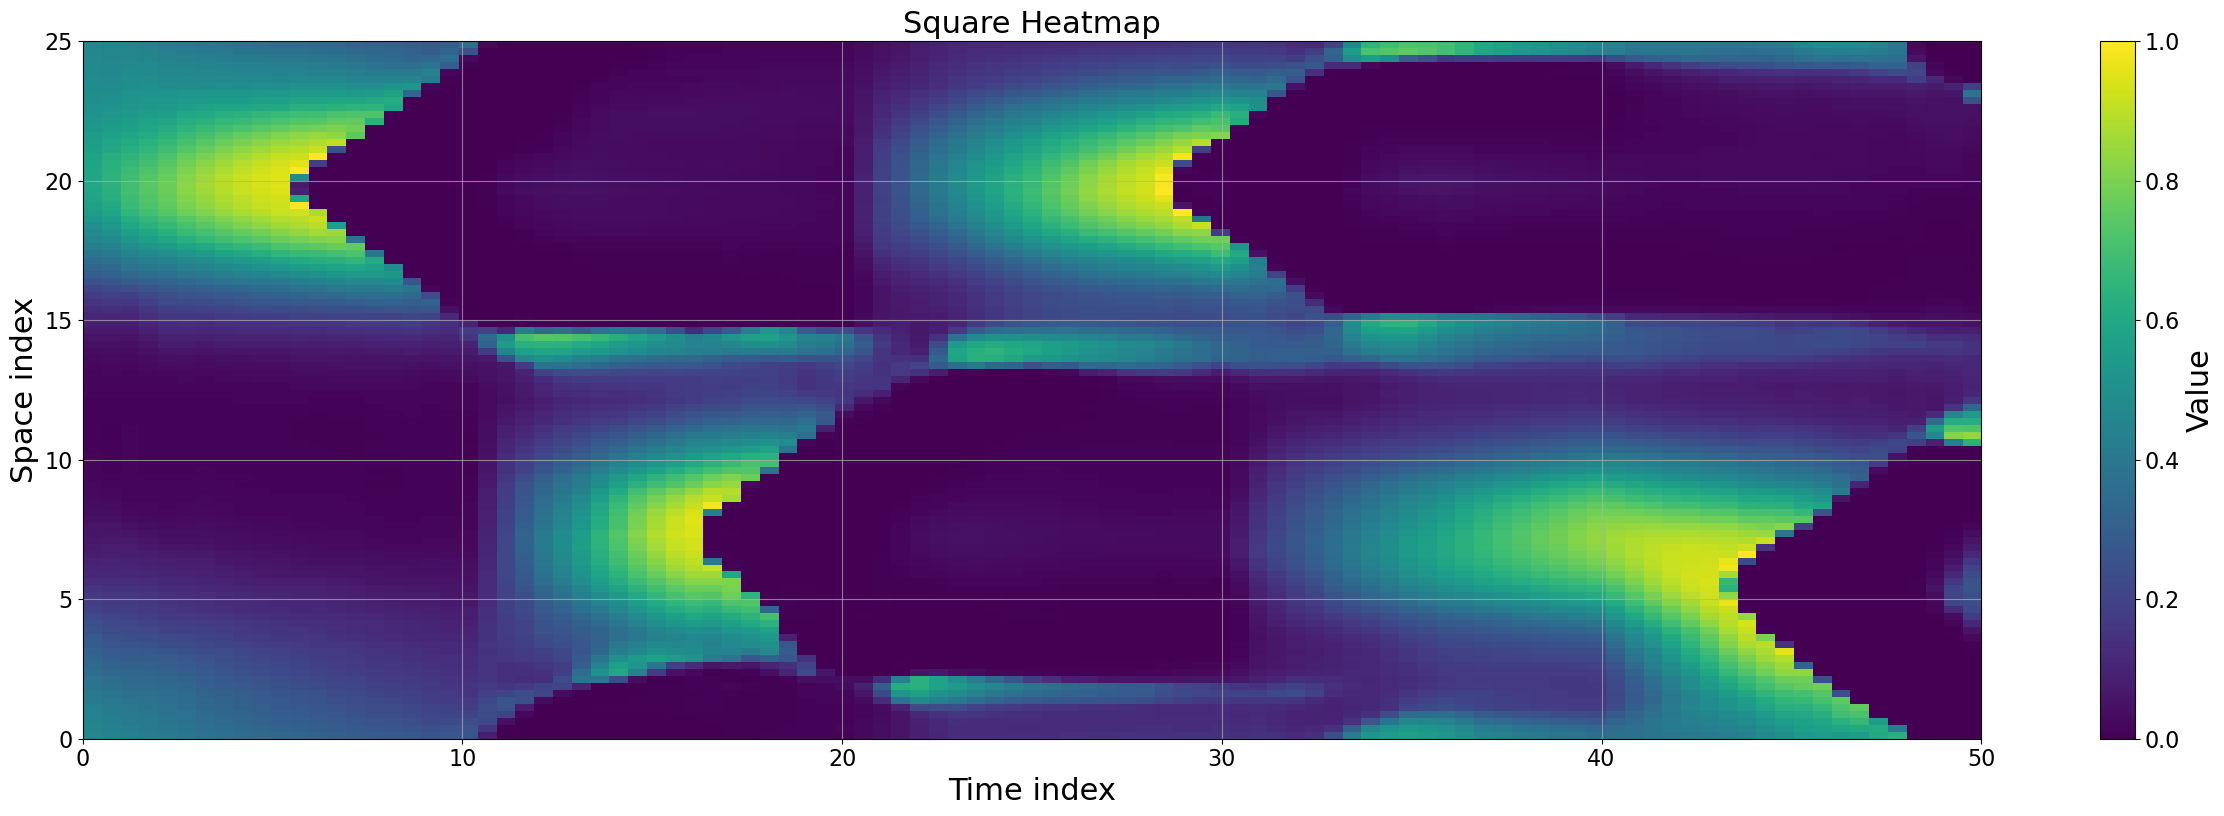

In [301]:
# === Plot style ===
mpl.rcParams.update({
    'text.usetex': False,
    'axes.titlesize': 22,
    'axes.labelsize': 22,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 20,
    'font.size': 18,
    'axes.grid': True,
    'grid.linestyle': '-',
    'grid.alpha': 0.7,
    'lines.linewidth': 1.5,
    'figure.figsize': [25, 8.5],  # width x height
})
plt.figure()  # force figure to be square
plt.imshow(y_pred, aspect='auto', origin='lower', cmap='viridis', vmin=0, vmax=1,extent=[0, 50, 0, 25])
plt.colorbar(label='Value')
plt.xlabel('Time index')     # or whatever your second dimension is
plt.ylabel('Space index')    # or whatever your first dimension is
plt.title('Square Heatmap')
plt.tight_layout()
plt.show()

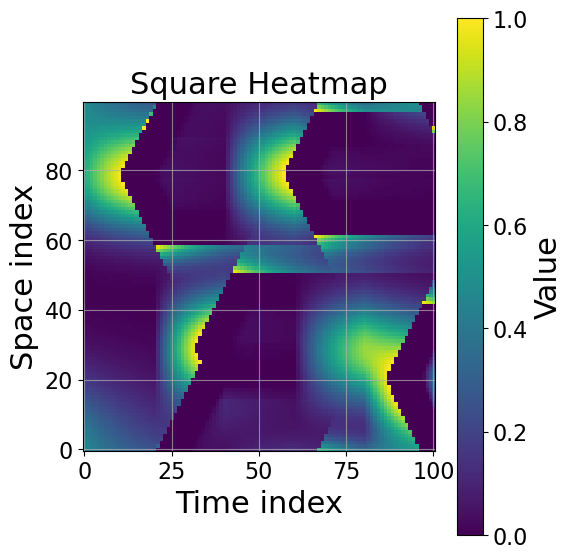

In [291]:

plt.figure(figsize=(6, 6))  # force figure to be square
plt.imshow(results['y'][trajectory].T, aspect='equal', origin='lower', cmap='viridis', vmin=0, vmax=1)
plt.colorbar(label='Value')
plt.xlabel('Time index')     # or whatever your second dimension is
plt.ylabel('Space index')    # or whatever your first dimension is
plt.title('Square Heatmap')
plt.tight_layout()
plt.show()

In [10]:
def plot_trajectory_multiple_trajectories(
    y, y_pred_list, t_feed,
    labels=None,
    time_indices=[61, 120, 181],
    space_indices=[21, 50, 78]
):
    '''
    Args:
        y: Ground truth array of shape (nt, nx)
        y_pred_list: List of prediction arrays, each of shape (nt, nx)
        t_feed: Time array of shape (nt,)
        labels: List of legend labels [ground_truth, pred1, pred2, ...]
    '''
    
    # === Plot style ===
    mpl.rcParams.update({
        'text.usetex': False,
        'axes.titlesize': 22,
        'axes.labelsize': 22,
        'xtick.labelsize': 16,
        'ytick.labelsize': 16,
        'legend.fontsize': 20,
        'font.size': 18,
        'axes.grid': True,
        'grid.linestyle': '-',
        'grid.alpha': 0.7,
        'lines.linewidth': 1.5,
        'figure.figsize': [25, 8.5],  # width x height
    })
    colors = ["black", "#0072BD", "#D95319", "#77AC30", "#7E2F8E"]
    linestyles = ['-', '--', ':', '-.', '-']

    y_np = y.T
    y_pred_np_list = [np.flip(y_pred, axis=0).T for y_pred in y_pred_list]
#     y_pred_np_list = [y_pred.T for y_pred in y_pred_list]
    
    t_feed = np.flip(t_feed)
    all_data = [y_np] + y_pred_np_list
    global_min = min(arr.min() for arr in all_data)
    global_max = max(arr.max() for arr in all_data)

    x = np.linspace(0, 25, y.shape[1])

    n_cols = min(4, len(time_indices))
    n_rows = 2

    fig, axs = plt.subplots(n_rows, n_cols,dpi=100,
                        sharex='row')

    if n_cols == 1:
        axs = axs.reshape(n_rows, 1)

    x = np.linspace(0, 25, y.shape[1])

    for i, t in enumerate(time_indices):
        ax = axs[0, i]
        ax.plot(x, y_np[:, t], label=labels[0], color=colors[0], linestyle=linestyles[0])
        for j, y_pred_np in enumerate(y_pred_np_list):
            ax.plot(x, y_pred_np[:, t],
                    label=labels[j + 1] if labels else f"Pred {j+1}",
                    color=colors[(j + 1) % len(colors)],
                    linestyle=linestyles[(j + 1) % len(linestyles)])
        ax.set_ylim(global_min, global_max)
        print(t)
        print(t_feed.shape)
        t_feed[t].item()
        ax.set_title(f"b = {t_feed[t].item():.0f}")
        ax.grid(True)
        # Remove individual labels
        ax.set_xlabel('x')
        ax.set_ylabel('')

    for i, idx in enumerate(space_indices):
        ax = axs[1, i]
        ax.plot(t_feed, y_np[idx, :], label=labels[0], color=colors[0], linestyle=linestyles[0])
        for j, y_pred_np in enumerate(y_pred_np_list):
            ax.plot(t_feed, y_pred_np[idx, :],
                    label=labels[j + 1] if labels else f"Pred {j+1}",
                    color=colors[(j + 1) % len(colors)],
                    linestyle=linestyles[(j + 1) % len(linestyles)])
        ax.set_ylim(global_min, global_max)
        ax.set_title(f"a = {x[idx]:.0f}")
        ax.grid(True)
        # Remove individual labels
        ax.set_xlabel('t')
        ax.set_ylabel('')

   
    fig.text(0.01, 0.76,r'u(x,t=b)', va='center', ha='center',
         rotation='vertical', fontsize=20)

    # Second row shared y-axis label
    fig.text(0.01, 0.30, r'u(x=a,t)', va='center', ha='center',
         rotation='vertical', fontsize=20)

#     Add legend as before
    handles, legend_labels = axs[0, 0].get_legend_handles_labels()
    legend = fig.legend(handles, legend_labels,
                        loc='center right',
                        frameon=True,
                        framealpha=1.0,
                        edgecolor='black',
                        facecolor='white',
                        ncol=1)
    legend.set_draggable(True)

    fig.tight_layout(rect=[0.02, 0.02, 1, 1],h_pad=2.0,w_pad=1)  # leave space for labels and legend

    return fig